File name: Investigation_1.ipynb               
Author: Florian Imorde                      
Latest Update: 16.07.2019                      

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.cluster import KMeans
from bokeh.plotting import figure, show, output_notebook, gridplot
from bokeh.tile_providers import CARTODBPOSITRON

# 0) Task

**Questions:**

The businesses stored inside the YELP dataset are located widely across North America. In which regions are the most businesses? Does the geographical location have influence on the ration behavior of the users?

**Approach:**

Step 1: Cluster the businesses into different regions. <br>
Step 2: Investigate via descriptive analysis possible differences between the regions.

# 1) Preprocessing

## 1.1) Load the data

In [2]:
path_dataset_business = '../Data/yelp_dataset/business.json'
df = pd.read_json(path_dataset_business, lines=True)

In [3]:
df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


## 1.2) EDA (exploratory data analysis)

In [4]:
df.describe()

,is_open,latitude,longitude,review_count,stars
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000
mean,0.823040,38.541803,-97.594785,33.538962,3.585627
std,0.381635,4.941964,16.697725,110.135224,1.018458
min,0.000000,33.204642,-115.493471,3.000000,1.000000
25%,1.000000,33.637408,-112.274677,4.000000,3.000000
50%,1.000000,36.144815,-111.759323,9.000000,3.500000
75%,1.000000,43.602989,-79.983614,25.000000,4.500000
max,1.000000,51.299943,-72.911982,8348.000000,5.000000


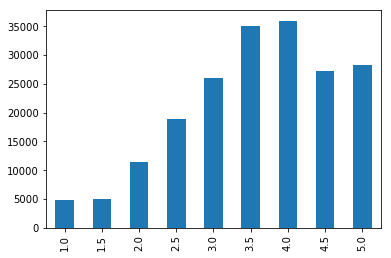

In [5]:
# Distribution of the star ratings
star_count = df['stars'].value_counts()
star_count.reindex([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]).plot.bar()

In [6]:
# Number of businesses
len_business = len(df['business_id'])
# Number of cities
len_unique_cities = len(df['city'].unique())
# Number of postal codes
len_unique_postal_code = len(df['postal_code'].unique())

print('Number of businesses:   ', len_business)
print('Number of cities:       ', len_unique_cities)
print('Number of postal codes: ', len_unique_postal_code)

Number of businesses:    192609
Number of cities:        1204
Number of postal codes:  17541


## 1.3) Visualize the locations

In [7]:
def transform_mercator(Coords):
    """ Transformation of longitude and latitude coordinates into the mercator format.
    
    Parameters:
        Coords: List ([latitute, logitute]) with the coordinates of one point      
    Return:
        (x,y): Transformation of Coords
        
    """ 
    lat = Coords[0]
    lon = Coords[1]
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [8]:
def transform_mercator_dataframe(Coords):
    """ Transformation of longitude and latitude coordinates into the mercator format.
    
    Parameters:
        Coords: DataFrame with the columns 'latitute' and 'logitute'      
    Return:
        (x,y): Transformation of Coords
        
    """ 
    for i in range(len(Coords['latitude'])):
        lat = Coords['latitude']
        lon = Coords['longitude']
        r_major = 6378137.000
        x = r_major * lon.apply(lambda x: math.radians(x))
        scale = x/lon
        y = 180.0/math.pi * lat.apply(lambda x: math.log(math.tan(math.pi/4.0 + x * (math.pi/180.0)/2.0))) * scale    
    return (x, y)

In [9]:
# Boundaries of the US (130°W - 60°W, 30°N - 55°N)
x_b1, y_b1= transform_mercator([30, -130])
x_b2, y_b2= transform_mercator([55, -60])

In [10]:
# Plot the business locations
p = figure(x_range=(x_b1, x_b2), y_range=(y_b1, y_b2), x_axis_type="mercator", y_axis_type="mercator")
p.sizing_mode = 'scale_width'
p.plot_height = 400

# Load businesses as circles in the map
# Info: Not all businesses are loaded into the table
x_p, y_p = transform_mercator_dataframe(df.sample(n=1000, random_state=42))
p.circle(x = x_p, y = y_p)

p.add_tile(CARTODBPOSITRON)
p.title.text = "Locations of businesses (representative sample)"

output_notebook()
show(p)

Loading BokehJS ...

The visualization of the data shows, that the businesses are located in a just few areas. They are not wildly distributed across the America.

# 2) Clustering

Task: Cluster the businesses. Businesses in the same area should be grouped together.

In [11]:
# The number of clusters k -- which should be build up -- has to be defined.
# Set up a range for k, to determine the best parameter:
k_min = 2
k_max = 20

In [12]:
score_kmeans = []

# Build up the different clusters with k in [k_min, k_max]
for i in range(k_min, k_max+1):
    print('Build up Kmeans for k =', i)
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df[['latitude', 'longitude']])
    score_kmeans.append(kmeans.inertia_)

Build up Kmeans for k = 2
Build up Kmeans for k = 3
Build up Kmeans for k = 4
Build up Kmeans for k = 5
Build up Kmeans for k = 6
Build up Kmeans for k = 7
Build up Kmeans for k = 8
Build up Kmeans for k = 9
Build up Kmeans for k = 10
Build up Kmeans for k = 11
Build up Kmeans for k = 12
Build up Kmeans for k = 13
Build up Kmeans for k = 14
Build up Kmeans for k = 15
Build up Kmeans for k = 16
Build up Kmeans for k = 17
Build up Kmeans for k = 18
Build up Kmeans for k = 19
Build up Kmeans for k = 20


In [13]:
# Plot the kmeans error for different k
p = figure(plot_width=400, plot_height=400)
p.plot_width=800
p.plot_height=400

p.line(range(k_min, k_max), score_kmeans, line_width=2)

p.title.text = "Kmeans Error"
p.xaxis.axis_label = 'New xlabel'
p.yaxis.axis_label = 'Error'

show(p)

The upper plot visualizes the clustering error dependent on the different k values. 

In analogy of the 'elbow method' the best Cluster is gained with k = 8. With a higher value k the error will decrease further - but only very slowly. Simultaneously the efficiency will decrease. 

# 3) Deskriptiv Snalysis

In [14]:
# Build up clusters with k = 8
k = 8

In [15]:
kmeans_final = KMeans(n_clusters=k, random_state=0).fit(df[['latitude', 'longitude']])
cluster_center = kmeans_final.cluster_centers_

In [16]:
# Transform the cluster center into mercator format
cc_x = []
cc_y = []

for i in range(k):
    x, y = transform_mercator(cluster_center[i])
    cc_x.append(x)
    cc_y.append(y)

In [17]:
# Plot the business locations
p = figure(x_range=(x_b1, x_b2), y_range=(y_b1, y_b2), x_axis_type="mercator", y_axis_type="mercator")
p.sizing_mode = 'scale_width'
p.plot_height = 400

# Load cluster center as circles in the map
colors = ['red', 'navy', 'gray', 'brown', 'cyan', 'lime', 'orange', 'darkgreen']
for i in range(len(cc_x)):
    p.circle(x = cc_x[i], y = cc_y[i], size=50, color=colors[i], alpha=0.7, legend="Cluster "+str(i))

x_p, y_p = transform_mercator_dataframe(df.sample(n=500, random_state=42))
p.circle(x = x_p, y = y_p, color="black")

p.add_tile(CARTODBPOSITRON)
p.title.text = "Locations of businesses (representative sample)"

output_notebook()
show(p)

Loading BokehJS ...

The map locates the business with the color black. The big, colored circle represent the clusters.

In [18]:
# Create a dictionary to describe the area of each cluster:
cluster_dict = {0:'Montreal' ,
                1:'Las Vegas' , 
                2:'Pittsburg_Cleaveland', 
                3:'Calgary', 
                4:'Phoenix', 
                5:'Charlotte', 
                6:'Toronto', 
                7:'Madision_Urbana'}

In [19]:
# Add the cluster as a new feature to the dataframe df
df['cluster'] = kmeans_final.predict(df[['latitude', 'longitude']])
df['cluster_name'] = [cluster_dict[x] for x in df['cluster']]

In [20]:
# Numer of businesses per cluster
cluster_grouped = df[['business_id', 'cluster_name', 'cluster']].groupby(['cluster_name', 'cluster'])
cluster_grouped.count().sort_values(by =['business_id'], ascending=False)

,,business_id
cluster_name,cluster,
Phoenix,4,56712
Las Vegas,1,36337
Toronto,6,33421
Pittsburg_Cleaveland,2,25916
Charlotte,5,15882
Montreal,0,9244
Calgary,3,8008
Madision_Urbana,7,7089


The right column of the upper column shows the number of businesses in each cluster. It can be detected, that there are big differences. Example given: Cluster 4 has 8 times more businesses than cluster 7.

In [21]:
# Calculate the number and the distribution of star ratings
star_count_cluster_0 = df[df['cluster'] == 0]['stars'].value_counts()
star_count_cluster_1 = df[df['cluster'] == 1]['stars'].value_counts()
star_count_cluster_2 = df[df['cluster'] == 2]['stars'].value_counts()
star_count_cluster_3 = df[df['cluster'] == 3]['stars'].value_counts()
star_count_cluster_4 = df[df['cluster'] == 4]['stars'].value_counts()
star_count_cluster_5 = df[df['cluster'] == 5]['stars'].value_counts()
star_count_cluster_6 = df[df['cluster'] == 6]['stars'].value_counts()
star_count_cluster_7 = df[df['cluster'] == 7]['stars'].value_counts()

star_count_cluster_0 = star_count_cluster_0.reset_index()
star_count_cluster_0.columns = ['stars', 'count']
star_count_cluster_0['stars'] = star_count_cluster_0['stars'].astype(float)

star_count_cluster_1 = star_count_cluster_1.reset_index()
star_count_cluster_1.columns = ['stars', 'count']
star_count_cluster_1['stars'] = star_count_cluster_1['stars'].astype(float)

star_count_cluster_2 = star_count_cluster_2.reset_index()
star_count_cluster_2.columns = ['stars', 'count']
star_count_cluster_2['stars'] = star_count_cluster_2['stars'].astype(float)

star_count_cluster_3 = star_count_cluster_3.reset_index()
star_count_cluster_3.columns = ['stars', 'count']
star_count_cluster_3['stars'] = star_count_cluster_3['stars'].astype(float)

star_count_cluster_4 = star_count_cluster_4.reset_index()
star_count_cluster_4.columns = ['stars', 'count']
star_count_cluster_4['stars'] = star_count_cluster_4['stars'].astype(float)

star_count_cluster_5 = star_count_cluster_5.reset_index()
star_count_cluster_5.columns = ['stars', 'count']
star_count_cluster_5['stars'] = star_count_cluster_5['stars'].astype(float)

star_count_cluster_6 = star_count_cluster_6.reset_index()
star_count_cluster_6.columns = ['stars', 'count']
star_count_cluster_6['stars'] = star_count_cluster_6['stars'].astype(float)

star_count_cluster_7 = star_count_cluster_7.reset_index()
star_count_cluster_7.columns = ['stars', 'count']
star_count_cluster_7['stars'] = star_count_cluster_7['stars'].astype(float)

In [22]:
# Plot the distribution of star ratings for the 8 clusters
WIDTH=250
HEIGHT=250

p0 = figure(title="Cluster 0", width=WIDTH, plot_height=HEIGHT)
p0.vbar(x=star_count_cluster_0['stars'], top=star_count_cluster_0['count'], width=0.3)
p0.xaxis.axis_label = 'Stars'
p0.yaxis.axis_label = 'Count'

p1 = figure(title="Cluster 1", width=WIDTH, plot_height=HEIGHT)
p1.vbar(x=star_count_cluster_1['stars'], top=star_count_cluster_1['count'], width=0.3)
p1.xaxis.axis_label = 'Stars'
p1.yaxis.axis_label = 'Count'

p2 = figure(title="Cluster 2", width=WIDTH, plot_height=HEIGHT)
p2.vbar(x=star_count_cluster_2['stars'], top=star_count_cluster_2['count'], width=0.3)
p2.xaxis.axis_label = 'Stars'
p2.yaxis.axis_label = 'Count'

p3 = figure(title="Cluster 3", width=WIDTH, plot_height=HEIGHT)
p3.vbar(x=star_count_cluster_3['stars'], top=star_count_cluster_3['count'], width=0.3)
p3.xaxis.axis_label = 'Stars'
p3.yaxis.axis_label = 'Count'

p4 = figure(title="Cluster 4", width=WIDTH, plot_height=HEIGHT)
p4.vbar(x=star_count_cluster_4['stars'], top=star_count_cluster_4['count'], width=0.3)
p4.xaxis.axis_label = 'Stars'
p4.yaxis.axis_label = 'Count'

p5 = figure(title="Cluster 5", width=WIDTH, plot_height=HEIGHT)
p5.vbar(x=star_count_cluster_5['stars'], top=star_count_cluster_5['count'], width=0.3)
p5.xaxis.axis_label = 'Stars'
p5.yaxis.axis_label = 'Count'

p6 = figure(title="Cluster 6", width=WIDTH, plot_height=HEIGHT)
p6.vbar(x=star_count_cluster_6['stars'], top=star_count_cluster_6['count'], width=0.3)
p6.xaxis.axis_label = 'Stars'
p6.yaxis.axis_label = 'Count'

p7 = figure(title="Cluster 7", width=WIDTH, plot_height=HEIGHT)
p7.vbar(x=star_count_cluster_7['stars'], top=star_count_cluster_7['count'], width=0.3)
p7.xaxis.axis_label = 'Stars'
p7.yaxis.axis_label = 'Count'

p01 = gridplot([[p0, p1]])
p23 = gridplot([[p2, p3]])
p45 = gridplot([[p4, p5]])
p67 = gridplot([[p6, p7]])

show(p01)
show(p23)
show(p45)
show(p67)

Regional differences and similarities between the ratings and the businesses can be recognized. 

Example given:
* The largest number of businesses in Cluster 1 and Cluster 4 are rated with 5 stars.
* The group of 5 star rated businesses in Cluster 0 and Cluster 6 are relatively low.    
* In all clusters the 1 and 1.5 star ratings are approximately equal. Furthermore those ratings are comparatively low in contrast to the other ratings.

# 4) Outlook

The upper investigation can be extended for example with the following questions:
    * Are businesses (and therefor the categories) changing with the region? (Concrete Example: Has cluster 1 more Sushi Bars and have therefor the Sushi Bars a percentage higher rating?
    * Are businesses rated differently in different regions? (Concrete Example: Is there a correlation between the business attributes and the regions?)
    * What features should a business have, to be successful in a region?
    * ...